<a href="https://colab.research.google.com/github/lmj900830/NLP_TermProject_Group20_Eng/blob/master/Friends_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Dialog in Friends

**Model: based on multi-calss sentiment analysis with BERT**

## 0. System Requirements.

The specifications for training is as follows:

In [ ]:
!nvidia-smi

Sun Jun 28 22:40:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Add the required python packages

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 675kB 7.4MB/s 
     |████████████████████████████████| 3.8MB 39.0MB/s 
     |████████████████████████████████| 890kB 42.4MB/s 
     |████████████████████████████████| 1.1MB 41.3MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 2.11.0


## 1. Load the Data

- Preprocess the data
- Convert to pandas dataframe

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import json
import re

def load_data(path):
    global_tokenized_dialog, global_string_label = [], []
    for dialog in json.loads(open(path, 'r', encoding='utf-8').read()):
        tokenized_dialog, string_label = [], []
        for utter in dialog:
            temp_str = re.sub(r'[\u0092\x92\']',"'",utter['utterance'].lower())

            tokenized_dialog.append(temp_str)
            string_label.append(utter['emotion'])
        global_tokenized_dialog.append(tokenized_dialog)
        global_string_label.append(string_label)
    
    global_ids_label = []
    for string_label in global_string_label:
        ids_label = []
        for str_label in string_label:
            if str_label == 'neutral':
                ids_label.append(0)
            elif str_label == 'joy':
                ids_label.append(1)
            elif str_label == 'sadness':
                ids_label.append(2)
            elif str_label == 'fear':
                ids_label.append(3)
            elif str_label == 'anger':
                ids_label.append(4)
            elif str_label == 'surprise':
                ids_label.append(5)
            elif str_label == 'disgust':
                ids_label.append(6)
            else:
                ids_label.append(7)
        global_ids_label.append(ids_label)
    
    return global_tokenized_dialog, global_ids_label

def load_data_list(filename):
    a, b = load_data(filename)

    results = []
    for i in range(len(a)):
        for j in range(len(a[i])):
            results.append((a[i][j], b[i][j]))
    return results

In [3]:
data_train = load_data_list('/content/friends_train.json')
data_test = load_data_list('/content/friends_train.json')

In [ ]:
print(data_train)

[("also i was the point person on my company's transition from the kl-5 to gr-6 system.", 0), ("you must've had your hands full.", 0), ('that i did. that i did.', 0), ("so let's talk a little bit about your duties.", 0), ('my duties?  all right.', 5), ("now you'll be heading a whole division, so you'll have a lot of duties.", 0), ('i see.', 0), ("but there'll be perhaps 30 people under you so you can dump a certain amount on them.", 0), ('good to know.', 0), ('we can go into detail', 0), ("no don't i beg of you!", 3), ("all right then, we'll have a definite answer for you on monday, but i think i can say with some confidence, you'll fit in well here.", 0), ('really?!', 5), ('absolutely.  you can relax; you did great.', 0), ('but then who? the waitress i went out with last month?', 5), ('you know? forget it!', 7), ('no-no-no-no, no! who, who were you talking about?', 5), ("no, i-i-i-i don't, i actually don't know", 7), ('ok!', 0), ('all right, well...', 0), ("i'm gonna see if i can get 

### 1.1 Build BERT Dataset

Specific format required for BERT analysis:

1. col 0: GUID
2. col 1: Class Label for row
3. col 2: Dummy Column
4. col 3: text to classify

In [ ]:
df_bert = pd.DataFrame({
    'id': range(len(data_train)),
    'label': [a[1] for a in data_train],
    'alpha': ['a']*len(data_train),
    'text': [a[0] for a in data_train]
})

df_bert.head()

,id,label,alpha,text
0,0,0,a,also i was the point person on my company's tr...
1,1,0,a,you must've had your hands full.
2,2,0,a,that i did. that i did.
3,3,0,a,so let's talk a little bit about your duties.
4,4,5,a,my duties? all right.


## 2. Data Processing

First, split the data into train and test datasets

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df_bert_train, df_bert_test = train_test_split(df_bert, test_size=0.01)
df_bert_val, df_bert_test = train_test_split(df_bert_test, test_size=0.5)

print(df_bert_train.shape, df_bert_test.shape, df_bert_val.shape)

(10455, 4) (53, 4) (53, 4)


### 2.1 Data Visualization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Neutral, Joy, Sadness, Anger, Neg Neutral (1-5)')

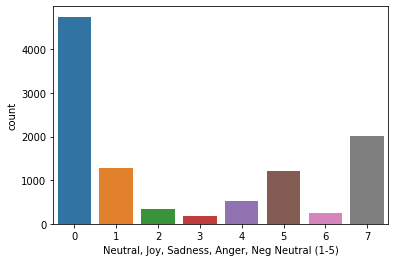

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_bert.label)
plt.xlabel('Neutral, Joy, Sadness, Anger, Neg Neutral (1-5)')

### 2.2 Data Preprocessing

Convert text to numbers, add padding, add separators

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Choose a tokenizer length by visualization

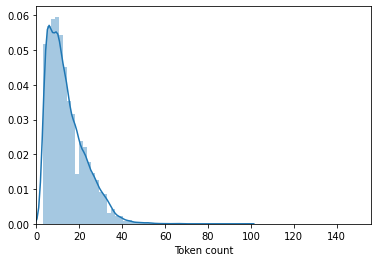

In [ ]:
token_lens = []

for txt in df_bert.text:
    tokens = tokenizer.encode(txt, max_length=800)
    token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 156]);
plt.xlabel('Token count');

Most of the text in the "Friends" Dialog contains less than 60 Tokens.

However, we will set the max token size to 100 just in case.

### 2.3 Helper Functions for Torch Implementation

In [ ]:
MAX_LEN=100

In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        text=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

Create batches from our training data

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_bert_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_bert_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_bert_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## 3. Sentiment Analysis with BERT

In [ ]:
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from torch import nn

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

### 3.1 Run with CUDA GPU acceleration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentClassifier(8)
model = model.to(device)

Move example batch of training data to cuda device

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


## Training using AdamW Optimizer

Train BERT model using correct weight decay

In [ ]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

BERT authors recommends the following hyperparameters for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

However, we will be using a different number of epochs

**Create two helper functions: one for training, one for evaluating the model**

In [ ]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
    return correct_predictions.double() / n_examples, np.mean(losses)

### Train the Model!!

In [ ]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_bert_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_bert_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.09936326085159944 accuracy 0.9670970827355333
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 2/20
----------
Train loss 0.09730339289211386 accuracy 0.9675753228120517
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 3/20
----------
Train loss 0.09877848832033907 accuracy 0.9670014347202296
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 4/20
----------
Train loss 0.09780191675035728 accuracy 0.9669057867049259
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 5/20
----------
Train loss 0.09962136263262042 accuracy 0.9666188426590149
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 6/20
----------
Train loss 0.09940757824114056 accuracy 0.9670970827355333
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 7/20
----------
Train loss 0.09786678025681797 accuracy 0.9670970827355333
Val   loss 1.7154268026351929 accuracy 0.07547169811320754

Epoch 8/20
--

## 4. Plot our Modl's Accuracy

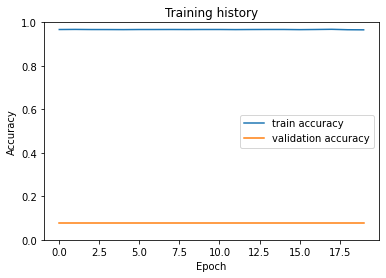

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names=['neutral', 'joy', 'sadness', 'fear', 'anger', 'surprise','non neutral'] 

print(classification_report(y_test, y_pred, target_names=class_names)) 

              precision    recall  f1-score   support

     neutral       0.47      0.56      0.51        16
         joy       0.38      0.30      0.33        10
     sadness       0.25      0.25      0.25         4
        fear       0.00      0.00      0.00         1
       anger       1.00      0.43      0.60         7
    surprise       0.00      0.00      0.00         0
 non neutral       0.17      0.20      0.18        15

    accuracy                           0.36        53
   macro avg       0.32      0.25      0.27        53
weighted avg       0.41      0.36      0.37        53



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


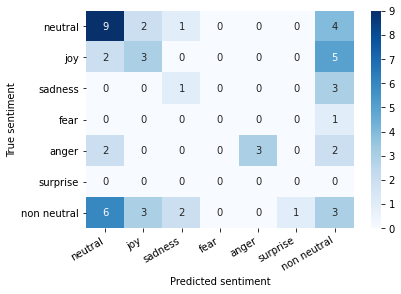

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 6. Accuracy

test a single text

In [ ]:
from textwrap import wrap

idx = 7

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

NameError: ignored

In [ ]:
# See the confidence of each category interval

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

NameError: ignored